# Семинар 7 - Сверточные нейронные сети (Convolution neural network)

In [11]:
import random
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

In [12]:
from keras.datasets import cifar10

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [14]:
print('В трейне: ', x_train.shape[0], 'объектов, в тесте: ', x_test.shape[0])

В трейне:  50000 объектов, в тесте:  10000


In [15]:
num_classes = 10 #
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

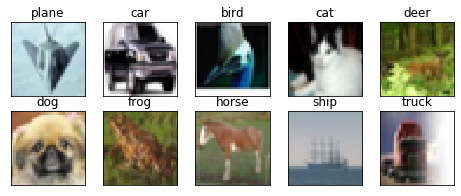

In [16]:
# Сгенерируем случаные примеры для каждого класса
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [17]:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=1000, train_size=49000)

In [18]:
print('Training data shape: ', x_train.shape)
print('Validation data shape: ', x_val.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (49000, 32, 32, 3)
Validation data shape:  (1000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


In [19]:
from sklearn.metrics import accuracy_score

In [20]:
from keras.models import Sequential # Модель, где все слои соединены друг с другом
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten # Слой, где все нйероны предыдущего уровня соединены с нейронами следующего
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD

In [21]:
np.random.seed(18)

x_train = x_train.astype('float32')
x_val= x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

In [22]:
y_train_ohe = np_utils.to_categorical(y_train, num_classes=num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes=num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes=num_classes)

__Baseline:__

- Convolutional input layer, 16 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.
- Convolutional layer, 16 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.
- Flatten layer.
- Fully connected layer with 128 units and a rectifier activation function.
- Dropout set to 50%.
- Fully connected output layer with 10 units and a softmax activation function.

In [72]:
epochs = 3
lrate = 0.01
decay = lrate/epochs

In [73]:
# Создаем последовательную модель
model = Sequential()

# Добавляем слои
model.add(Conv2D(32, (7, 7), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (7, 7), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Компилируем модель
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        50208     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [74]:
# Обучаем модель! 
model.fit(x_train, y_train_ohe,
              epochs=epochs,
              validation_data=(x_val, y_val_ohe),
              shuffle=True)

Train on 49000 samples, validate on 1000 samples
Epoch 1/3
49000/49000 [==============================] - 65s 1ms/step - loss: 1.8091 - acc: 0.3389 - val_loss: 1.5179 - val_acc: 0.4470
Epoch 2/3
49000/49000 [==============================] - 65s 1ms/step - loss: 1.5433 - acc: 0.4417 - val_loss: 1.4080 - val_acc: 0.4760
Epoch 3/3
49000/49000 [==============================] - 65s 1ms/step - loss: 1.4580 - acc: 0.4770 - val_loss: 1.3434 - val_acc: 0.5050


In [75]:
#Сохраним модель и веса
with open('cnn.json', 'w') as model_file:
            model_file.write(model.to_json())

model.save_weights('cnn.h5')

In [76]:
from keras.models import model_from_json
json_file = open("cnn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model.load_weights("cnn.h5")

In [77]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        50208     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [78]:
predict = loaded_model.predict(x_test)

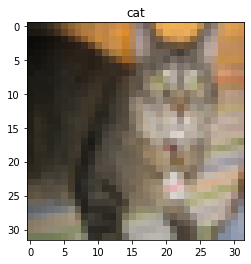

plane 0.0021014663
car 0.0016491908
bird 0.19447616
cat 0.32192123
deer 0.05022728
dog 0.20246282
frog 0.20686407
horse 0.017341113
ship 0.0005430758
truck 0.002413593


In [79]:
# Проверим случаный семпл:
num_pred = np.random.randint(0,999)
plt.title(class_names[np.where(y_test_ohe[num_pred]==1)[0][0]])
plt.imshow(x_test[num_pred])
plt.show()
for i,j in enumerate(class_names):
    print(j, predict[num_pred][i])

In [80]:
accuracy_score(y_test, loaded_model.predict_classes(x_test))

0.5141

In [81]:
from keras import Model

In [87]:
# Функция для отрисовки фильтров
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(4,8, figsize=(16,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(32):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i+1))

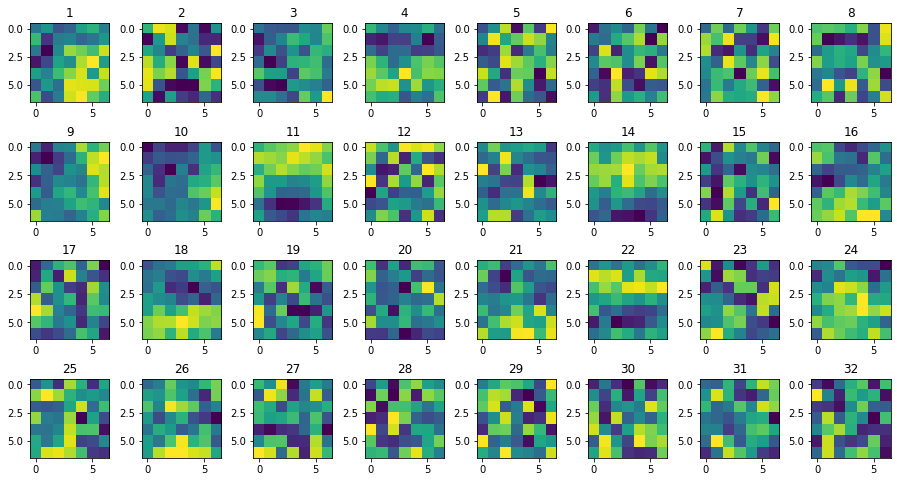

In [88]:
plot_conv_weights(loaded_model, 'conv2d_7')

In [89]:
activation_model = Model(inputs=loaded_model.input, 
                         outputs=loaded_model.layers[0].output)
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4736      
Total params: 4,736
Trainable params: 4,736
Non-trainable params: 0
_________________________________________________________________


In [90]:
test_img = np.expand_dims(x_test[num_pred], axis=0)
activation = activation_model.predict(test_img)
print(activation.shape)

(1, 32, 32, 32)


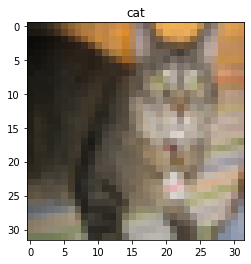

In [100]:
plt.title(class_names[np.where(y_test_ohe[num_pred]==1)[0][0]])
plt.imshow(x_test[num_pred])
plt.show()

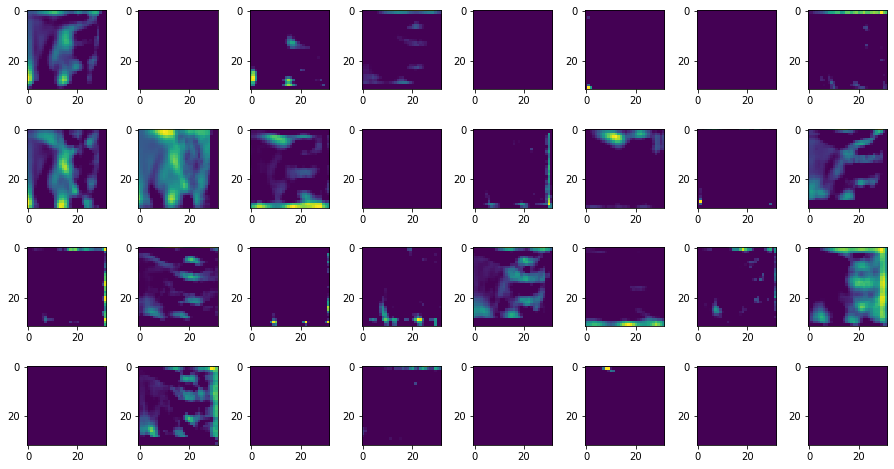

In [101]:
fig, axs = plt.subplots(4,8, figsize=(16,8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(activation[0, :, :, i], cmap='viridis')
    #axs[i].set_title(str(i+1))